In [396]:
from __future__ import division

import numpy as np
import os
from glob import glob

from PIL import Image
from copy import deepcopy

from sklearn import linear_model, datasets, neighbors
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import svm

%matplotlib inline
from scipy.misc import imread, imresize
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

import pandas as pd

import scipy.stats as stats
from scipy.stats import norm
import sklearn

In [361]:
## define path to input datasets (tidy format) (see analysis_helpers.py) for definitions
path_to_recog = '/home/jefan/neurosketch/neurosketch_voxelmat_freesurfer_recog'
# path_to_draw = '/home/jefan/neurosketch/neurosketch_voxelmat_freesurfer_drawing' 
## 3/16/18: switch to drawing data with same smoothing applied during preprocessing as to recognition runs
path_to_draw = '/home/jefan/neurosketch/neurosketch_voxelmat3mm_freesurfer_drawing'
roi_list = np.array(['V1','V2','LOC','IT','fusiform','parahippo', 'PRC', 'ento','hipp','mOFC'])

In [362]:
## get raw file list for recognition runs
RECOG_METAS = sorted([i for i in os.listdir(path_to_recog) if i.split('.')[-1]=='csv'])
RECOG_FEATS = sorted([i for i in os.listdir(path_to_recog) if i.split('.')[-1]=='npy'])
RECOG_SUBS = np.array([i.split('_')[0] for i in RECOG_FEATS])

recog_sub_list = np.unique(RECOG_SUBS)

def preprocess_recog(RECOG_METAS, RECOG_FEATS):
    M = [i for i in RECOG_METAS if len(i.split('.')[0].split('_'))==4]
    F = [i for i in RECOG_FEATS if len(i.split('.')[0].split('_'))==4]
    return M,F

RECOG_METAS, RECOG_FEATS = preprocess_recog(RECOG_METAS, RECOG_FEATS)

In [363]:
## get raw file list for drawing runs
DRAW_METAS = sorted([i for i in os.listdir(path_to_draw) if i.split('.')[-1]=='csv'])
DRAW_FEATS = sorted([i for i in os.listdir(path_to_draw) if i.split('.')[-1]=='npy'])
DRAW_SUBS = np.array([i.split('_')[0] for i in DRAW_FEATS])
draw_sub_list = np.unique(DRAW_SUBS)

In [364]:
## get subject ID's that have complete datasets from all phases of experiment
sub_list = np.intersect1d(recog_sub_list,draw_sub_list)
print 'Number of subs: {}'.format(len(sub_list))

Number of subs: 31


In [365]:
## filter file list so only contains the sessions that have full datasets
def extract_good_sessions(DRAW_METAS,DRAW_FEATS,RECOG_METAS,RECOG_FEATS):
    _DRAW_METAS = [i for i in DRAW_METAS if i.split('_')[1] in sub_list]
    _DRAW_FEATS = [i for i in DRAW_FEATS if i.split('_')[0] in sub_list]
    _RECOG_METAS = [i for i in RECOG_METAS if i.split('_')[1] in sub_list]
    _RECOG_FEATS = [i for i in RECOG_FEATS if i.split('_')[0] in sub_list]
    return _DRAW_METAS, _DRAW_FEATS, _RECOG_METAS, _RECOG_FEATS

DRAW_METAS,DRAW_FEATS,RECOG_METAS,RECOG_FEATS =  \
extract_good_sessions(DRAW_METAS,DRAW_FEATS,RECOG_METAS,RECOG_FEATS)

RECOG_SUBS = np.array([i.split('_')[0]+'_neurosketch' for i in RECOG_FEATS])
RECOG_ROIS = np.array([i.split('_')[1] for i in RECOG_FEATS])

DRAW_SUBS = np.array([i.split('_')[0]+'_neurosketch' for i in DRAW_FEATS])
DRAW_ROIS = np.array([i.split('_')[1] for i in DRAW_FEATS])

### How well do we do at classifying the target when we train on recognition patterns only?

In [366]:
#### Helper data loader functions
def cleanup_df(df):    
    surplus = [i for i in df.columns if 'Unnamed' in i]
    df = df.drop(surplus,axis=1)
    return df

def load_draw_meta(this_sub):
    this_file = 'metadata_{}_drawing.csv'.format(this_sub)
    x = pd.read_csv(os.path.join(path_to_draw,this_file))
    x = cleanup_df(x)
    x['trial_num'] = np.repeat(np.arange(40),23)        
    return x
    
def load_draw_feats(this_sub,this_roi):
    this_file = '{}_{}_featurematrix.npy'.format(this_sub,this_roi)
    y = np.load(os.path.join(path_to_draw,this_file))
    y = y.transpose()
    return y

def load_draw_data(this_sub,this_roi):
    x = load_draw_meta(this_sub)
    y = load_draw_feats(this_sub,this_roi)
    assert y.shape[0] == x.shape[0]    
    return x,y

def load_recog_meta(this_sub,this_roi,this_phase):
    this_file = 'metadata_{}_{}_{}.csv'.format(this_sub,this_roi,this_phase)
    x = pd.read_csv(os.path.join(path_to_recog,this_file))
    x = cleanup_df(x)
    return x
    
def load_recog_feats(this_sub,this_roi,this_phase):
    this_file = '{}_{}_{}_featurematrix.npy'.format(this_sub,this_roi,this_phase)
    y = np.load(os.path.join(path_to_recog,this_file))
    y = y.transpose()
    return y    

def load_recog_data(this_sub,this_roi,this_phase):
    x = load_recog_meta(this_sub,this_roi,this_phase)
    y = load_recog_feats(this_sub,this_roi,this_phase)
    assert y.shape[0] == x.shape[0]    
    return x,y

# z-score normalization to de-mean & standardize variances within-voxel 
def normalize(X):
    X = X - X.mean(0)
    X = X / np.maximum(X.std(0), 1e-5)
    return X

def bootstrapCI(x,nIter):
    '''
    input: x is an array
    '''
    u = []
    for i in np.arange(nIter):
        inds = np.random.RandomState(i).choice(len(x),len(x))
        boot = x[inds]
        u.append(np.mean(boot))
        
    p1 = len([i for i in u if i<0])/len(u) * 2
    p2 = len([i for i in u if i>0])/len(u) * 2
    p = np.min([p1,p2])
    U = np.mean(u)
    lb = np.percentile(u,2.5)
    ub = np.percentile(u,97.5)    
    return U,lb,ub,p

## plotting helper
def get_prob_timecourse(iv,DM,version='4way'):
    trained_objs = np.unique(DM.label.values)
    control_objs = [i for i in ['bed','bench','chair','table'] if i not in trained_objs]    
    
    if version=='4way':
        t1 = trained_objs[0]
        t2 = trained_objs[1]
        c1 = control_objs[0]
        c2 = control_objs[1]
        target = np.vstack((DM[DM.label==t1].groupby(iv)['t1_prob'].mean().values,
                       DM[DM.label==t2].groupby(iv)['t2_prob'].mean().values)).mean(0) ## target timecourse
        foil = np.vstack((DM[DM.label==t1].groupby(iv)['t2_prob'].mean().values,
                       DM[DM.label==t2].groupby(iv)['t1_prob'].mean().values)).mean(0) ## foil timecourse
        control = np.vstack((DM[DM.label==t1].groupby(iv)['c1_prob'].mean().values,
                            DM[DM.label==t1].groupby(iv)['c2_prob'].mean().values,
                            DM[DM.label==t2].groupby(iv)['c1_prob'].mean().values,
                            DM[DM.label==t2].groupby(iv)['c2_prob'].mean().values)).mean(0) ## control timecourse    
    elif version=='3way':
        t1 = trained_objs[0]
        t2 = trained_objs[1]
        target = np.vstack((DM[DM.label==t1].groupby(iv)['t1_prob'].mean().values,
                       DM[DM.label==t2].groupby(iv)['t2_prob'].mean().values)).mean(0) ## target timecourse; mean is taken over what?
        foil = np.vstack((DM[DM.label==t1].groupby(iv)['t2_prob'].mean().values,
                       DM[DM.label==t2].groupby(iv)['t1_prob'].mean().values)).mean(0) ## foil timecourse
        control = np.vstack((DM[DM.label==t1].groupby(iv)['c_prob'].mean().values,
                            DM[DM.label==t2].groupby(iv)['c_prob'].mean().values)).mean(0) ## control timecourse
        
    elif version=='2way':
        t1 = trained_objs[0]
        t2 = trained_objs[1]
        target = np.vstack((DM[DM.label==t1].groupby(iv)['t1_prob'].mean().values,
                       DM[DM.label==t2].groupby(iv)['t2_prob'].mean().values)).mean(0) ## target timecourse; mean is taken over what?
        foil = np.vstack((DM[DM.label==t1].groupby(iv)['t2_prob'].mean().values,
                       DM[DM.label==t2].groupby(iv)['t1_prob'].mean().values)).mean(0) ## foil timecourse
        
        control = np.zeros(len(foil))        
        
    return target, foil, control

## plotting helper
def get_prob_timecourse_alt(iv,DM):
    trained_objs = np.unique(DM.label.values)
    control_objs = [i for i in ['bed','bench','chair','table'] if i not in trained_objs]
    t1 = trained_objs[0]
    t2 = trained_objs[1]
    c1 = control_objs[0]
    c2 = control_objs[1]
    target = np.vstack((DM[DM.label==t1].groupby(iv)['{}_prob'.format(t1)].mean().values,
                   DM[DM.label==t2].groupby(iv)['{}_prob'.format(t2)].mean().values)).mean(0) ## target timecourse
    foil = np.vstack((DM[DM.label==t1].groupby(iv)['{}_prob'.format(t2)].mean().values,
                   DM[DM.label==t2].groupby(iv)['{}_prob'.format(t1)].mean().values)).mean(0) ## foil timecourse
    control = np.vstack((DM[DM.label==t1].groupby(iv)['{}_prob'.format(c1)].mean().values,
                        DM[DM.label==t1].groupby(iv)['{}_prob'.format(c2)].mean().values,
                        DM[DM.label==t2].groupby(iv)['{}_prob'.format(c1)].mean().values,
                        DM[DM.label==t2].groupby(iv)['{}_prob'.format(c2)].mean().values)).mean(0) ## control timecourse    
    return target, foil, control
     
def flatten(x):
    return [item for sublist in x for item in sublist] 

In [367]:
## general plotting params
sns.set_context('poster')
colors = sns.color_palette("cubehelix", 5)

In [368]:
## example subject, roi, and phase (localizer is default)
this_sub = sub_list[0]
this_roi = roi_list[2] ## order is: ['V1','V2','LOC','IT','fusiform','parahippo', 'PRC', 'ento','hipp','mOFC']
this_phase = '12' ## options are '12', '34', '56'

### generate ALLDM supersubject matrix with classifier probabilities

In [2]:
import analysis_helpers as h
reload(h)
logged = [True,False]
versions = ['2way','3way','4way']

really_run = 1
if really_run:
    for l in logged:
        if l==True:
            tag = 'logged'
        elif l==False:
            tag = 'raw'
        for version in versions:
            roi_list_short = roi_list
            sub_list_short = sub_list
            ALLDM, Acc = analysis_helpers.make_drawing_predictions(sub_list_short,roi_list_short,version=version,logged=l)
            ALLDM.to_csv('./data/logistic_timeseries_drawing_neural_{}_{}.csv'.format(version,tag)) ## train recog, test drawing run    

ImportError: No module named analysis_helpers

In [370]:
Acc = np.array(Acc)
x = pd.DataFrame(Acc.transpose())
x.columns = roi_list_short

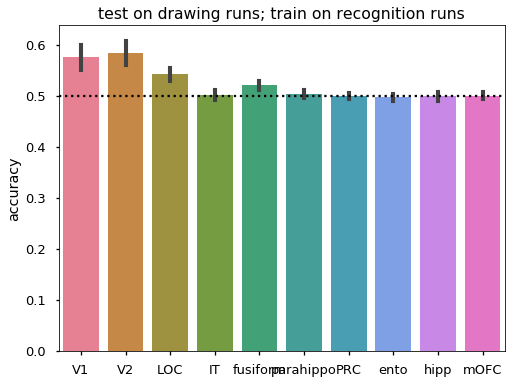

In [371]:
sns.set_context('talk')
plt.figure(figsize=(8,6))
sns.barplot(data=x,palette='husl',ci=95)
chance_dict = {'4way':0.25,'3way':0.33,'2way':0.5}
plt.axhline(chance_dict[version],linestyle=':',color='k')
plt.ylabel('accuracy')
plt.title('test on drawing runs; train on recognition runs')
# plt.ylim(0,0.35)

#### make summary timecourse plots


In [372]:
version = '4way'
tag = 'raw'
ALLDM = pd.read_csv('./logistic_timeseries_drawing_neural_{}_{}.csv'.format(version,tag))

In [373]:
run_this = 1

if run_this:
    sns.set_context('paper')
    subs = np.unique(ALLDM.subj.values)
    lookup = dict(zip(['trial_num','run_num','time_point'],['repetition','run','TR']))
    ivs = ['run_num','trial_num','time_point']
    this_iv = 'time_point'

    ## do you want to render the CONDITION-wise plots -- trained vs. foil vs control
    ## or the DIFFERENCE plots -- trained - foil vs foil - control?
    render_cond = 1

    for this_iv in ivs:
        for this_roi in roi_list:

            T = []
            F = []
            C = []
            Sub = []
            for sub in subs:
                inds =(ALLDM['roi']==this_roi) & (ALLDM['subj']==sub) 
                t,f,c = get_prob_timecourse(this_iv,ALLDM[inds],version=version)
                if len(T)==0:
                    T = t
                    F = f
                    C = c
                    DTF = t-f  ## these differences already in log space       
                    DTC = t-c
                    DFC = f-c
                else:
                    T = np.hstack((T,t))
                    F = np.hstack((F,f))        
                    C = np.hstack((C,c)) 
                    DTF = np.hstack((DTF,t-f))                
                    DTC = np.hstack((DTC,t-c))
                    DFC = np.hstack((DFC,f-c))
                Sub.append([sub]*len(t))   

            if render_cond==1:
                ## make longform version of dataframe to use in tsplot (by condition)            
                Trial = np.tile(np.arange(len(t)),len(subs)*3)
                Condition = np.repeat(['target','foil','control'],len(T))
                Sub = np.tile(np.array(flatten(Sub)),3)
                Prob = np.hstack((T,F,C))
                assert len(Trial)==len(Condition)
                assert len(Sub)==len(Prob)
                assert len(Condition)==len(Sub)
                x = pd.DataFrame([Prob,Trial,Condition,Sub])
                x = x.transpose()
                x.columns = ['probability',lookup[this_iv],'condition','sub']
                toop = 'condition'            
            else:
                ## make longform version of dataframe to use in tsplot (difference btw conditions)                    
                Trial = np.tile(np.arange(len(t)),len(subs)*3)
                Condition = np.repeat(['target-foil','target-control','foil-control'],len(T))
                Sub = np.tile(np.array(flatten(Sub)),3)
                Prob = np.hstack((DTF,DTC,DFC))        
                assert len(Trial)==len(Condition)
                assert len(Sub)==len(Prob)
                assert len(Condition)==len(Sub)
                x = pd.DataFrame([Prob,Trial,Condition,Sub])
                x = x.transpose()
                x.columns = ['probability',lookup[this_iv],'condition','sub']        
                toop = 'difference'
            fig = plt.figure(figsize=(8,4))
            ## plot it
            sns.tsplot(data=x,
                      time=lookup[this_iv],
                      unit='sub',
                      condition='condition',
                      value='probability',
                      ci=95)
            if render_cond==1:
                plt.ylim(0,0.5)
                plt.axhline(0.25,linestyle=':',color='k')  
                plt.legend(bbox_to_anchor=(0.8, 1.01))  
                plt.title('Classifier evidence by condition in {}'.format(this_roi))

            else:
                plt.ylim(-0.3,0.3)
                plt.axhline(0,linestyle=':',color='k')  
                plt.legend(bbox_to_anchor=(0.7, 1.01))                        
                plt.title('Difference in classifier evidence by condition in {}'.format(this_roi))        
            plt.xticks(np.arange(np.max(x[lookup[this_iv]].values)+1))
            if not os.path.exists('./plots/roi/{}/{}'.format(lookup[this_iv],toop)):
                os.makedirs('./plots/roi/{}/{}'.format(lookup[this_iv],toop))
            plt.tight_layout()        
            plt.savefig('./plots/roi/{}/{}/prob_timecourse_{}_by_{}_{}.pdf'.\
                        format(lookup[this_iv],toop,this_roi,lookup[this_iv],version))
            plt.close(fig)

/home/jefan/.local/lib/python2.7/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


#### get subject-level index of contrast between objects during drawing


In [400]:
lookup = dict(zip(['trial_num','run_num','time_point'],['repetition','run','TR']))
version = '4way'
tag = 'logged'
ALLDM = pd.read_csv('./data/logistic_timeseries_drawing_neural_{}_{}.csv'.format(version,tag))
ALLDM = cleanup_df(ALLDM)

In [403]:
reload(analysis_helpers)
sub_tf = []
sub_tc = []
sub_fc = []
roi = []

subs = np.unique(ALLDM.subj.values)
ivs = ['trial_num'] ## other options 'run_num','trial_num','time_point'

## do you want to render the CONDITION-wise plots -- trained vs. foil vs control
## or the DIFFERENCE plots -- trained - foil vs foil - control?
render_cond = 0

for this_iv in ivs:
    for this_roi in roi_list_short:

        T = []
        F = []
        C = []
        Sub = []
        for sub in subs:
            inds =(ALLDM['roi']==this_roi) & (ALLDM['subj']==sub) 
            t,f,c = analysis_helpers.get_prob_timecourse(this_iv,ALLDM[inds],version=version)
#             t,f,c = get_prob_timecourse_alt(this_iv,ALLDM[inds])                    
            if len(T)==0:
                T = t
                F = f
                C = c
                DTF = t-f               
                DTC = t-c
                DFC = f-c
            else:
                T = np.hstack((T,t))
                F = np.hstack((F,f))        
                C = np.hstack((C,c)) 
                DTF = np.hstack((DTF,t-f))                
                DTC = np.hstack((DTC,t-c))
                DFC = np.hstack((DFC,f-c))
            Sub.append([sub]*len(t))   
          
        ## make longform version of dataframe to use in tsplot (difference btw conditions)                    
        Trial = np.tile(np.arange(len(t)),len(subs)*3)
        Condition = np.repeat(['target-foil','target-control','foil-control'],len(T))
        Sub = np.tile(np.array(flatten(Sub)),3)
        Prob = np.hstack((DTF,DTC,DFC))        
        assert len(Trial)==len(Condition)
        assert len(Sub)==len(Prob)
        assert len(Condition)==len(Sub)
        x = pd.DataFrame([Prob,Trial,Condition,Sub])
        x = x.transpose()
        x.columns = ['probability',lookup[this_iv],'condition','sub']
        
        for this_sub in subs:
            sub_tf.append(x[(x['condition']=='target-foil') & (x['sub']==this_sub)]['probability'].mean())
            sub_tc.append(x[(x['condition']=='target-control') & (x['sub']==this_sub)]['probability'].mean())  
            sub_fc.append(x[(x['condition']=='foil-control') & (x['sub']==this_sub)]['probability'].mean()) 
            roi.append(this_roi)
            
        ## save out big dataframe with all subjects and timepoints
        x.to_csv('./data/difference_logprobs_{}_{}_{}.csv'.format(version,this_roi,this_iv))
            
## make dataframe with subject-level difference scores
d = pd.DataFrame([sub_tf,sub_tc,sub_fc,roi])
d = d.transpose()
d.columns = ['target-foil','target-control','foil-control','roi']
d = d.astype({'target-foil':'float64','target-control':'float64','foil-control':'float64'})

## print out target-foil ratios
print tag
if tag=='logged':
    print d.groupby('roi')['target-foil'].apply(lambda x: np.mean(np.exp(x)))
    d.to_csv('./data/difference_logprobs_{}.csv'.format(version))
else:
    print d.groupby('roi')['target-foil'].mean()
    d.to_csv('./data/difference_rawprobs_{}.csv'.format(version))


logged
roi
IT           1.023364
LOC          1.374080
PRC          0.962974
V1           1.999178
V2           2.195364
ento         0.983629
fusiform     1.148520
hipp         1.017162
mOFC         1.036091
parahippo    0.982014
Name: target-foil, dtype: float64


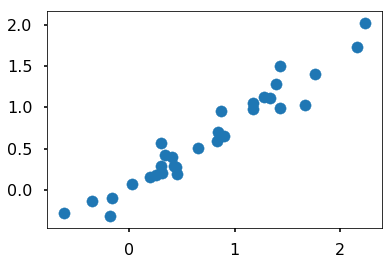

In [377]:
run_this = 1
if run_this:
    ## comparing 4-way and 2-way probability ratios
    d4way = pd.read_csv('difference_logprobs_4way.csv')
    d2way = pd.read_csv('difference_logprobs_2way.csv')
    inds = d4way['roi']=='V1'
    plt.scatter(d4way[inds]['target-foil'],d2way[inds]['target-foil'])

In [378]:
conditions = ['target-foil','target-control','foil-control']
for condition in conditions:
    print '------- condition: {} -------'.format(condition)
    for this_roi in roi_list:
        data = d[d['roi']==this_roi][condition].values
        U,lb,ub,p = bootstrapCI(data,3000)
        print 'ROI = {} | mean = {}  95% CI: [{} {}] p={}'.format(this_roi,np.round(U,5),np.round(lb,3),np.round(ub,5),np.round(p,5))

------- condition: target-foil -------
ROI = V1 | mean = 0.75017  95% CI: [0.504 1.0017] p=0.0
ROI = V2 | mean = 0.9154  95% CI: [0.646 1.19759] p=0.0
ROI = LOC | mean = 0.4984  95% CI: [0.362 0.64094] p=0.0
ROI = IT | mean = -0.01446  95% CI: [-0.083 0.05634] p=0.67467
ROI = fusiform | mean = 0.15795  95% CI: [0.074 0.2414] p=0.0
ROI = parahippo | mean = -0.01011  95% CI: [-0.089 0.06775] p=0.798
ROI = PRC | mean = -0.03706  95% CI: [-0.102 0.03167] p=0.288
ROI = ento | mean = -0.07157  95% CI: [-0.164 0.01311] p=0.10733
ROI = hipp | mean = -0.01947  95% CI: [-0.106 0.0602] p=0.67333
ROI = mOFC | mean = -0.0108  95% CI: [-0.083 0.05947] p=0.766
------- condition: target-control -------
ROI = V1 | mean = 0.3255  95% CI: [0.188 0.48339] p=0.0
ROI = V2 | mean = 0.42921  95% CI: [0.291 0.57743] p=0.0
ROI = LOC | mean = 0.25139  95% CI: [0.14 0.37358] p=0.0
ROI = IT | mean = 0.00725  95% CI: [-0.054 0.06717] p=0.81067
ROI = fusiform | mean = 0.113  95% CI: [0.039 0.18517] p=0.00267
ROI = p

u'/home/jefan/neurosketch'

### read in pre-post changes

In [451]:
version = '4way'
tag = 'log'
d = pd.read_csv('./data/difference_{}probs_{}.csv'.format(tag,version))
prepost = pd.read_csv('./data/neural_changes_by_surfroi_and_subject.csv')

In [452]:
# h = plt.hist(d[d['roi']=='V1']['target-foil'].values)

In [453]:
#### for debugging purposes, just checking that these are the 
this_roi = 'V1'
draw = d[d['roi']==this_roi]['target-foil'].values
recog = prepost['tradiff_{}'.format(this_roi)].values-prepost['condiff_{}'.format(this_roi)].values
z = pd.DataFrame([draw,recog])
z = z.transpose()
z.columns=['draw','recog']
z = z.sort_values(by='draw')

import statsmodels.api as sm
import statsmodels.formula.api as smf

reg = smf.ols(formula='recog ~ draw', data = z).fit()
# reg.summary()

In [443]:
# data = sm.datasets.get_rdataset("dietox", "geepack").data
# md = smf.mixedlm("Weight ~ Time", data, groups=data["Pig"])

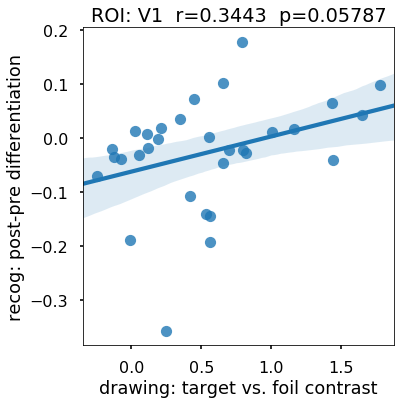

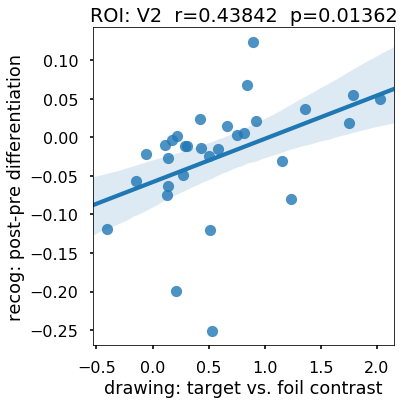

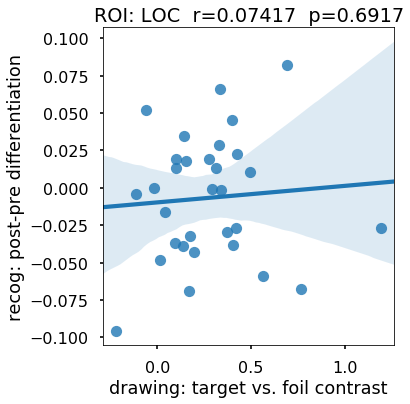

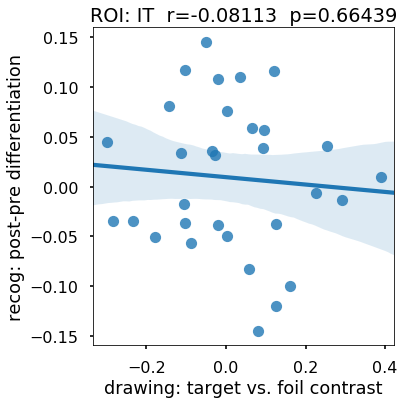

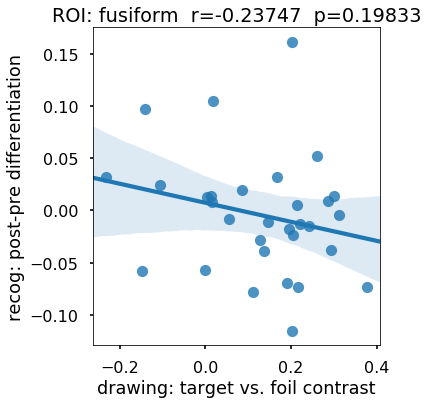

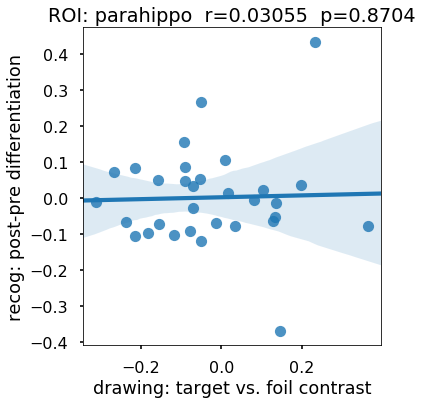

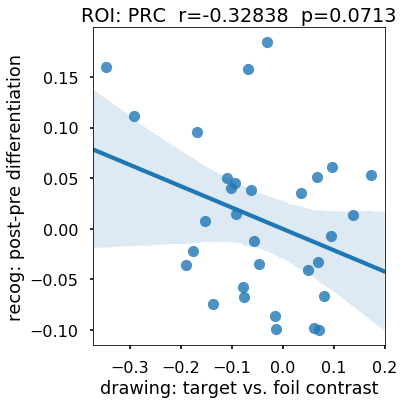

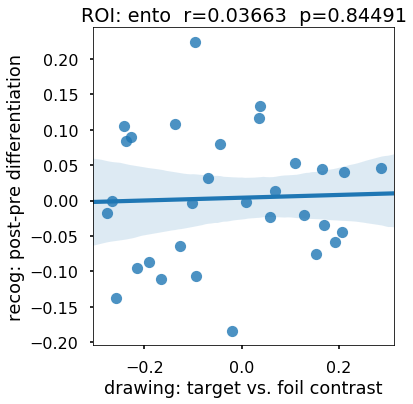

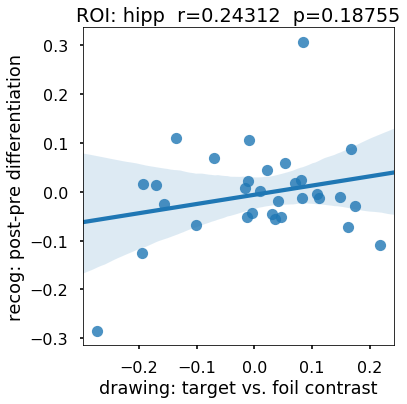

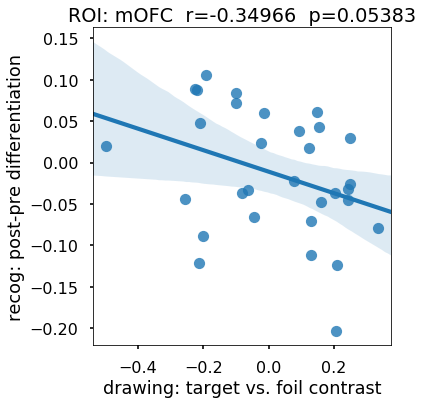

In [409]:
## make dataframe to relate drawing contrast to recognition differentiation
roi_list = ['V1', 'V2', 'LOC', 'IT', 'fusiform', 'parahippo', 'PRC', 'ento','hipp', 'mOFC']

for this_roi in roi_list:
#     draw = d[d['roi']==this_roi]['target-control'].values - d[d['roi']==this_roi]['foil-control'].values
    draw = d[d['roi']==this_roi]['target-foil'].values
    recog = prepost['tradiff_{}'.format(this_roi)].values-prepost['condiff_{}'.format(this_roi)].values
#     recog = prepost['tradiff_{}'.format(this_roi)].values

    z = pd.DataFrame([draw,recog])
    z = z.transpose()
    z.columns=['draw','recog']

    ## plot 
    fig = plt.figure(figsize=(6,6))
    sns.set_context('poster')
    sns.regplot(x="draw",
                y ="recog",
                data=z)
    r,p = stats.pearsonr(draw,recog)
    plt.title('ROI: {}  r={}  p={}'.format(this_roi,np.round(r,5),np.round(p,5)))
    plt.xlabel('drawing: target vs. foil contrast') 
    plt.ylabel('recog: post-pre differentiation')
    if not os.path.exists('./plots/roi/drawrecog'):
        os.makedirs('./plots/roi/drawrecog')
    plt.tight_layout()
    plt.savefig('./plots/roi/drawrecog/draw_recog_scatter_{}.pdf'.format(this_roi))
#     plt.close(fig)        

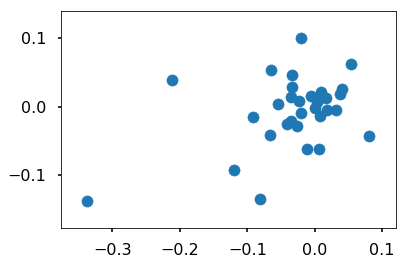

In [464]:
plt.scatter(prepost['tradiff_V2'],prepost['condiff_V2'])

### what about between different ROIs, e.g., V1 to hipp?

Does target-foil contrast in V1 correlate with hippocampal pre-post changes?

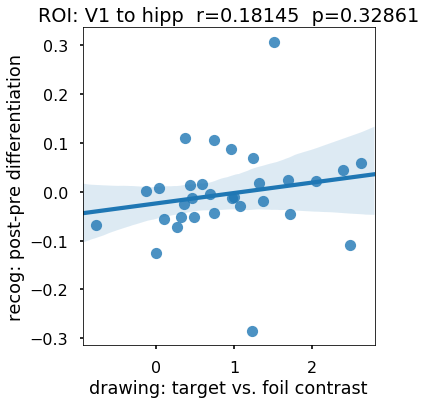

In [386]:
draw = d[d['roi']=='V2']['target-foil'].values
recog = prepost['tradiff_{}'.format('hipp')].values-prepost['condiff_{}'.format('hipp')].values

z = pd.DataFrame([draw,recog])
z = z.transpose()
z.columns=['draw','recog']

## plot 
fig = plt.figure(figsize=(6,6))
sns.set_context('poster')
sns.regplot(x="draw",
            y ="recog",
            data=z)
r,p = stats.pearsonr(draw,recog)
plt.title('ROI: {}  r={}  p={}'.format('V1 to hipp',np.round(r,5),np.round(p,5)))
plt.xlabel('drawing: target vs. foil contrast')
plt.ylabel('recog: post-pre differentiation')
if not os.path.exists('./plots/roi/drawrecog'):
    os.makedirs('./plots/roi/drawrecog')
plt.tight_layout()

### relate neural to vgg drawing time series

In [490]:
vgg_ts = pd.read_csv('./data/logistic_timeseries_drawing_vgg.csv')
neural_ts = pd.read_csv('./data/logistic_timeseries_drawing_neural.csv')

In [493]:
# vgg_ts = vgg_ts.drop(['Unnamed: 0','Unnamed: 0.1'],axis=1)
# vgg_ts.wID = [i.split('_')[0] for i in vgg_ts.wID.values]

In [494]:
vgg_ts.head()

,index,wID,viewpoint,trial,trialDuration,target,competitor,numSketch,bed,bench,chair,table,curr_winner,tc_pair,trialID,run,target_val,competitor_val,control_val
0,0,119174,20,320,39.00144,bench,chair,0,0.026822,0.055895,0.916243,0.001040,chair,bench/chair,0119174_neurosketch_320,1.0,0.055895,0.916243,0.013931
1,0,119174,20,320,39.00144,bench,chair,1,0.934225,0.026225,0.039085,0.000465,bed,bench/chair,0119174_neurosketch_320,1.0,0.026225,0.039085,0.467345
2,0,119174,20,320,39.00144,bench,chair,2,0.006035,0.970770,0.002714,0.020481,bench,bench/chair,0119174_neurosketch_320,1.0,0.970770,0.002714,0.013258
3,0,119174,20,320,39.00144,bench,chair,3,0.009842,0.978927,0.003784,0.007447,bench,bench/chair,0119174_neurosketch_320,1.0,0.978927,0.003784,0.008644
4,0,119174,20,320,39.00144,bench,chair,4,0.019298,0.967674,0.001463,0.011564,bench,bench/chair,0119174_neurosketch_320,1.0,0.967674,0.001463,0.015431


In [495]:
## plotting helper
def get_vgg_timecourse(iv,w):
    trained_objs = np.unique(w.target.values)
    control_objs = [i for i in ['bed','bench','chair','table'] if i not in trained_objs]
    t1 = trained_objs[0]
    t2 = trained_objs[1]
    c1 = control_objs[0]
    c2 = control_objs[1]
    target = np.vstack((w[w.target==t1].groupby(iv)['{}'.format(t1)].mean().values,
                   w[w.target==t2].groupby(iv)['{}'.format(t2)].mean().values)).mean(0) ## target timecourse
    foil = np.vstack((w[w.target==t1].groupby(iv)['{}'.format(t2)].mean().values,
                   w[w.target==t2].groupby(iv)['{}'.format(t1)].mean().values)).mean(0) ## foil timecourse
    control = np.vstack((w[w.target==t1].groupby(iv)['{}'.format(c1)].mean().values,
                        w[w.target==t1].groupby(iv)['{}'.format(c2)].mean().values,
                        w[w.target==t2].groupby(iv)['{}'.format(c1)].mean().values,
                        w[w.target==t2].groupby(iv)['{}'.format(c2)].mean().values)).mean(0) ## control timecourse

    return target, foil, control

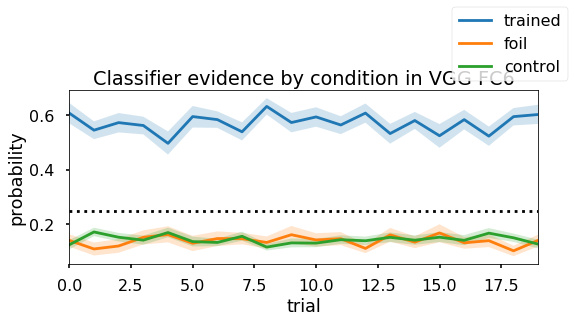

In [502]:
render_cond = 1

## get subject-level index of contrast between objects during drawing
sub_tf = []
sub_tc = []
sub_fc = []
roi = []

T = []
F = []
C = []
Sub = []

this_iv = 'trial' ## options: 'trial' and 'numSketch'
for this_sub in subs:
    inds = (vgg_ts['wID']==this_sub)
    w = vgg_ts[inds]
    t,f,c = get_vgg_timecourse(this_iv,w)
    
    if len(T)==0:
        T = t
        F = f
        C = c
        DTF = t-f                
        DTC = t-c
        DFC = f-c
    else:
        T = np.hstack((T,t))
        F = np.hstack((F,f))        
        C = np.hstack((C,c)) 
        DTF = np.hstack((DTF,t-f))                
        DTC = np.hstack((DTC,t-c))
        DFC = np.hstack((DFC,f-c))
    Sub.append([this_sub]*len(t))   

if render_cond==1:
    ## make longform version of dataframe to use in tsplot (by condition)            
    Trial = np.tile(np.arange(len(t)),len(subs)*3)
    Condition = np.repeat(['trained','foil','control'],len(T))
    Sub = np.tile(np.array(flatten(Sub)),3)
    Prob = np.hstack((T,F,C))
    assert len(Trial)==len(Condition)
    assert len(Sub)==len(Prob)
    assert len(Condition)==len(Sub)
    x = pd.DataFrame([Prob,Trial,Condition,Sub])
    x = x.transpose()
    x.columns = ['probability',this_iv,'condition','sub']
else:
    ## make longform version of dataframe to use in tsplot (difference btw conditions)                    
    Trial = np.tile(np.arange(len(t)),len(subs)*3)
    Condition = np.repeat(['trained-foil','trained-control','foil-control'],len(T))
    Sub = np.tile(np.array(flatten(Sub)),3)
    Prob = np.hstack((DTF,DTC,DFC))        
    assert len(Trial)==len(Condition)
    assert len(Sub)==len(Prob)
    assert len(Condition)==len(Sub)
    x = pd.DataFrame([Prob,Trial,Condition,Sub])
    x = x.transpose()
    x.columns = ['probability',this_iv,'condition','sub']
    
    for this_sub in subs:
        sub_tf.append(x[(x['condition']=='trained-foil') & (x['sub']==this_sub)]['probability'].mean())
        sub_tc.append(x[(x['condition']=='trained-control') & (x['sub']==this_sub)]['probability'].mean())  
        sub_fc.append(x[(x['condition']=='foil-control') & (x['sub']==this_sub)]['probability'].mean()) 
        roi.append('vgg_fc6')
        
    ## make dataframe with subject-level difference scores
    d2 = pd.DataFrame([sub_tf,sub_tc,sub_fc,roi])
    d2 = d2.transpose()
    d2.columns = ['trained-foil','trained-control','foil-control','roi']        

## plot it
fig = plt.figure(figsize=(8,4))
## plot it
sns.tsplot(data=x,
          time=this_iv,
          unit='sub',
          condition='condition',
          value='probability')
# plt.ylim(0,0.5)
plt.axhline(0.25,linestyle=':',color='k')  
plt.legend(bbox_to_anchor=(0.8, 1.01))  
plt.title('Classifier evidence by condition in VGG FC6')
plt.tight_layout()  

In [882]:
## make dataframe to relate drawing contrast to recognition differentiation
roi_list = ['V1', 'V2', 'LOC', 'IT', 'fusiform', 'parahippo', 'PRC', 'ento','hipp', 'mOFC']

for this_roi in roi_list:
    neural = d[d['roi']==this_roi]['trained-control'].values - d[d['roi']==this_roi]['foil-control'].values
    vgg = d2['trained-foil'].values

    z = pd.DataFrame([neural,vgg])
    z = z.transpose()
    z.columns=['neural','vgg']

    ## plot 
    fig = plt.figure(figsize=(6,6))
    sns.set_context('poster')
    sns.regplot(x="neural",
                y ="vgg",
                data=z)
    r,p = stats.pearsonr(neural,vgg)
    plt.title('ROI: {}  r={}  p={}'.format(this_roi,np.round(r,3),np.round(p,3)))
    if not os.path.exists('./plots/roi/neuralvgg'):
        os.makedirs('./plots/roi/neuralvgg')
    plt.tight_layout()
    plt.savefig('./plots/roi/neuralvgg/neural_vgg_scatter_{}.pdf'.format(this_roi))
    plt.close(fig)    
    